In [3]:
import pandas as pd               
import matplotlib.pyplot as plt
import seaborn as sns              
from wordcloud import WordCloud, STOPWORDS  
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
orders       = pd.read_csv('data/olist_orders_dataset.csv')
order_items  = pd.read_csv('data/olist_order_items_dataset.csv')
products     = pd.read_csv('data/olist_products_dataset.csv')
customers    = pd.read_csv('data/olist_customers_dataset.csv')
payments     = pd.read_csv('data/olist_order_payments_dataset.csv')
reviews      = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [5]:
orders['order_purchase_timestamp']      = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

<h3>Q1 – How many orders roll in each month—are some months busier than others?</h3>


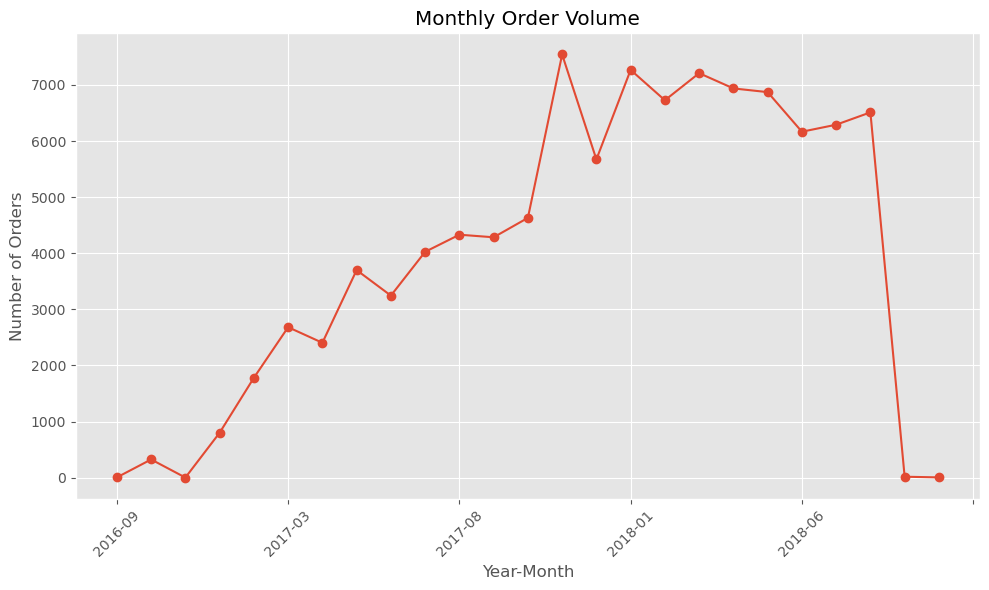

In [6]:
orders['year_month'] = orders['order_purchase_timestamp'].dt.to_period('M').astype(str)
orders_by_month = orders['year_month'].value_counts().sort_index()

plt.figure()
orders_by_month.plot(kind='line', marker='o')
plt.title('Monthly Order Volume')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<h3>Q2 – Which types of products pull in the most money?</h3>


In [15]:
cat_translate = pd.read_csv('data/product_category_name_translation.csv')
items_plus_products = pd.merge(order_items,
                               products[['product_id', 'product_category_name']],
                               on='product_id',
                               how='left')

In [16]:
items_plus_products = pd.merge(items_plus_products,
                               cat_translate,                
                               on='product_category_name',
                               how='left')

In [17]:
items_plus_products['cat_for_plot'] = items_plus_products[
    'product_category_name_english'
].fillna(items_plus_products['product_category_name'])



In [18]:
#revenue table
revenue_per_cat = (
    items_plus_products
      .groupby('cat_for_plot')['price']
      .sum()
      .sort_values(ascending=False)
      .head(15)
)

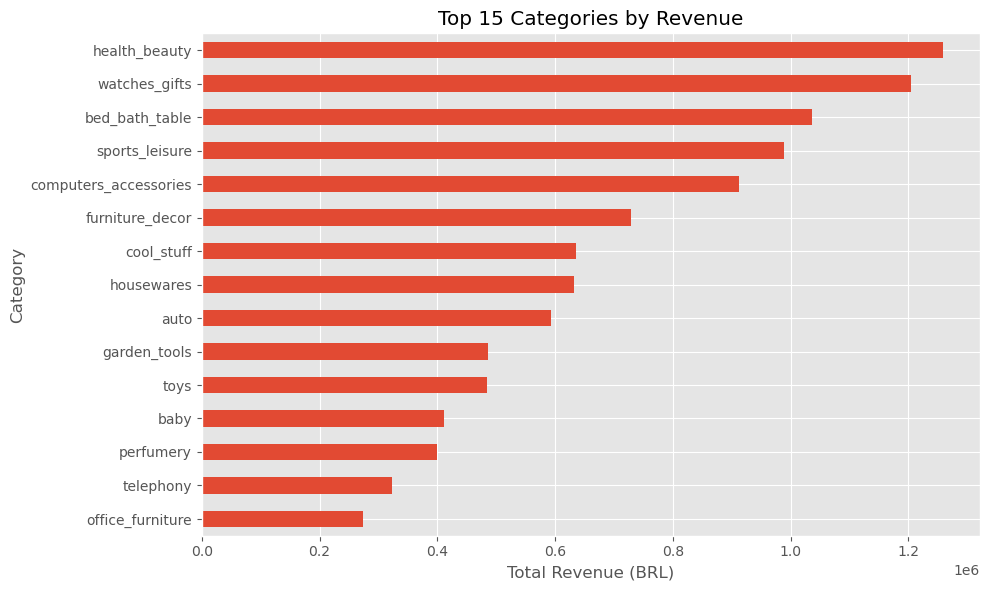

In [19]:
plt.figure()
revenue_per_cat.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Categories by Revenue')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


<h3>Q3 – What’s the top way shoppers choose to pay?</h3>


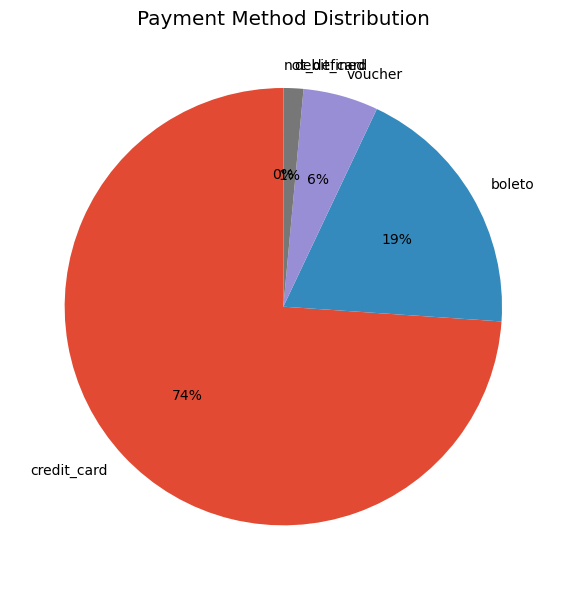

In [21]:
payment_counts = payments['payment_type'].value_counts()

plt.figure()
payment_counts.plot(kind='pie', autopct='%1.0f%%', startangle=90)
plt.title('Payment Method Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

<h3>Q4 – Which states get their packages quickest, and which ones wait the longest?</h3>


In [22]:
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] -
                                orders['order_purchase_timestamp']).dt.days

orders_with_state = pd.merge(orders, customers[['customer_id', 'customer_state']],
                             on='customer_id')

avg_delivery = orders_with_state.groupby('customer_state')['delivery_time_days'].mean()
avg_delivery = avg_delivery.sort_values()

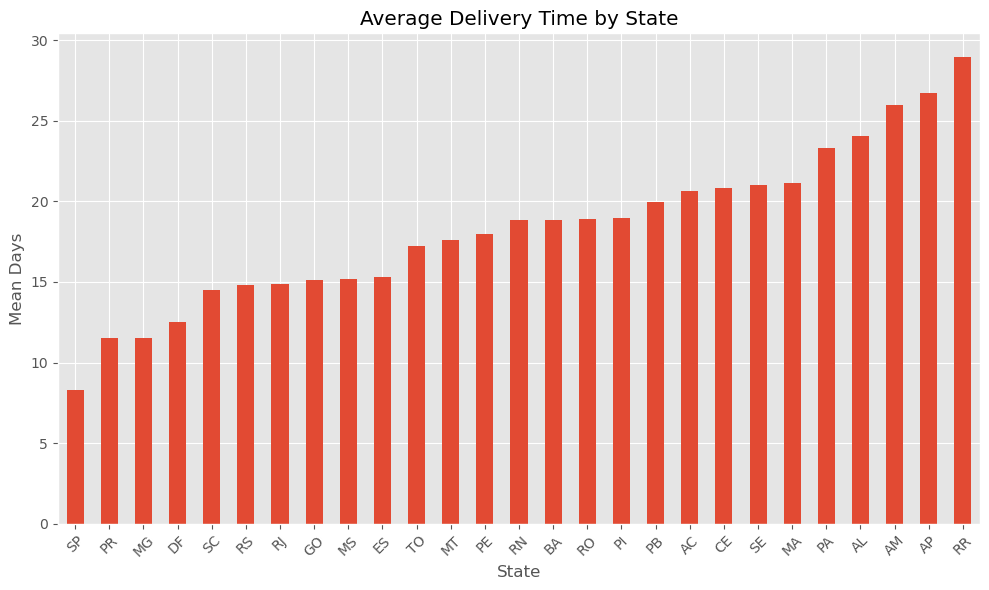

In [23]:
plt.figure()
avg_delivery.plot(kind='bar')
plt.title('Average Delivery Time by State')
plt.xlabel('State')
plt.ylabel('Mean Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Q5 – When delivery is late, do customers dish out lower ratings?</h3>


In [25]:
orders_reviews = pd.merge(orders[['order_id',
                                  'order_delivered_customer_date',
                                  'order_estimated_delivery_date']],
                          reviews[['order_id', 'review_score']],
                          on='order_id')

orders_reviews['delay_days'] = (orders_reviews['order_delivered_customer_date'] -
                                orders_reviews['order_estimated_delivery_date']).dt.days

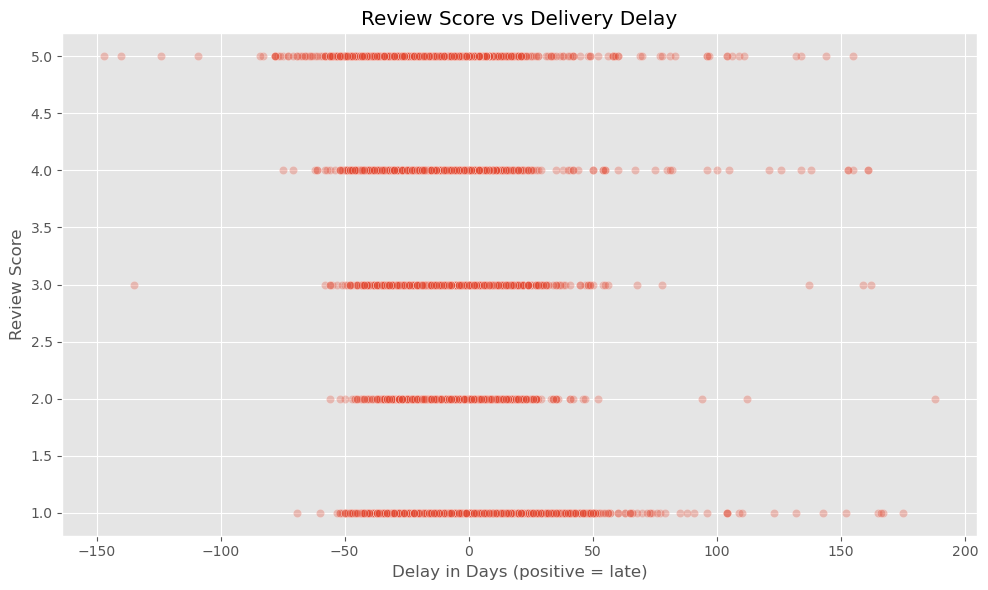

In [26]:
plt.figure()
sns.scatterplot(data=orders_reviews, x='delay_days', y='review_score', alpha=0.3)
plt.title('Review Score vs Delivery Delay')
plt.xlabel('Delay in Days (positive = late)')
plt.ylabel('Review Score')
plt.tight_layout()
plt.show()

<h3>Q6 – How many shoppers come back for another purchase?</h3>


In [35]:
orders_uid = orders.merge(customers[['customer_id', 'customer_unique_id']],on='customer_id', how='left')

orders_per_customer = orders_uid.groupby('customer_unique_id').size()
repeat_customers    = orders_per_customer[orders_per_customer > 1]
repeat_rate         = len(repeat_customers) / len(orders_per_customer) * 100

print(f'Repeat customer rate: {repeat_rate:.2f}%')   # ≈ 3 %


Repeat customer rate: 3.12%


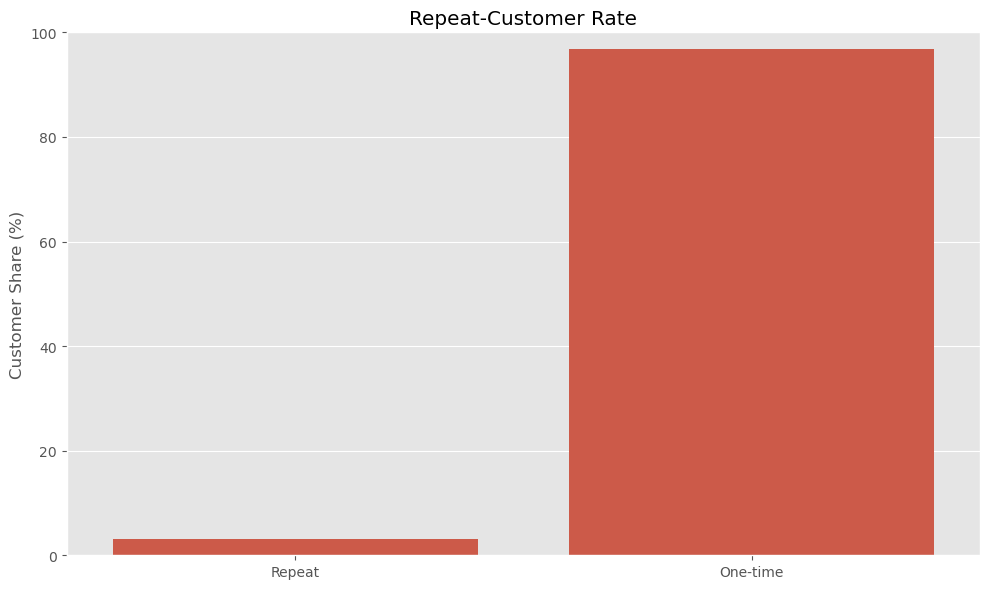

In [49]:
repeat_cnt = len(repeat_customers)

share_repeat = repeat_cnt / len(orders_per_customer) * 100
share_one    = 100 - share_repeat

plt.figure()
sns.barplot(x=['Repeat', 'One-time'],
            y=[share_repeat, share_one])
plt.ylabel('Customer Share (%)')
plt.title('Repeat-Customer Rate')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

<h3>Q7 – Do pricey carts make people split the bill into more installments?</h3>


In [40]:
#total merchandise revenue per order
order_totals = order_items.groupby('order_id')['price'].sum().rename('order_total')

#max installment count per order
order_installments = payments.groupby('order_id')['payment_installments'] \
                             .max() \
                             .rename('installments')

#combine and plot
inst_vs_total = pd.concat([order_totals, order_installments], axis=1).dropna()

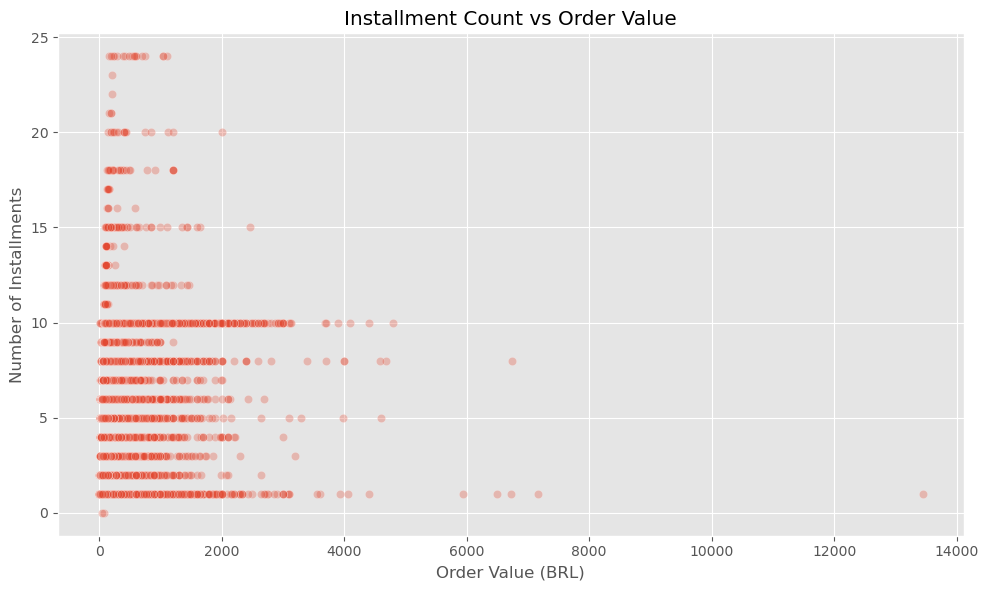

Order value ↔ Installments correlation: 0.31


In [41]:
sns.scatterplot(data=inst_vs_total,
                x='order_total',
                y='installments',
                alpha=0.3)

plt.title('Installment Count vs Order Value')
plt.xlabel('Order Value (BRL)')
plt.ylabel('Number of Installments')
plt.tight_layout()
plt.show()

corr = inst_vs_total['order_total'].corr(inst_vs_total['installments'])
print(f'Order value ↔ Installments correlation: {corr:.2f}')

<h3>Q8 – Which sellers earn the brightest review scores?</h3>


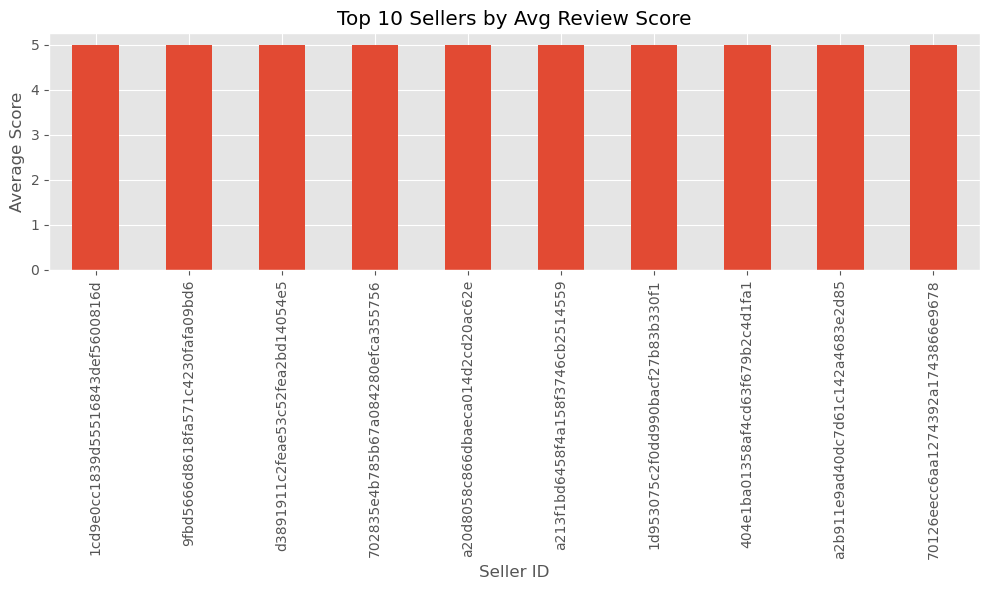

In [42]:
items_reviews = pd.merge(order_items[['order_id', 'seller_id']],
                         reviews[['order_id', 'review_score']],
                         on='order_id')

avg_score_per_seller = items_reviews.groupby('seller_id')['review_score'].mean()
top_sellers = avg_score_per_seller.sort_values(ascending=False).head(10)

plt.figure()
top_sellers.plot(kind='bar')
plt.title('Top 10 Sellers by Avg Review Score')
plt.xlabel('Seller ID')
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()


<h3>Q9 – Is the cancellation rate getting better—or worse—over time?</h3>


In [43]:
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M').astype(str)

total_by_month = orders['month'].value_counts().sort_index()
cancelled = orders[orders['order_status'] == 'canceled']
cancel_by_month = cancelled['month'].value_counts().sort_index()

cancel_rate = (cancel_by_month / total_by_month * 100).fillna(0)

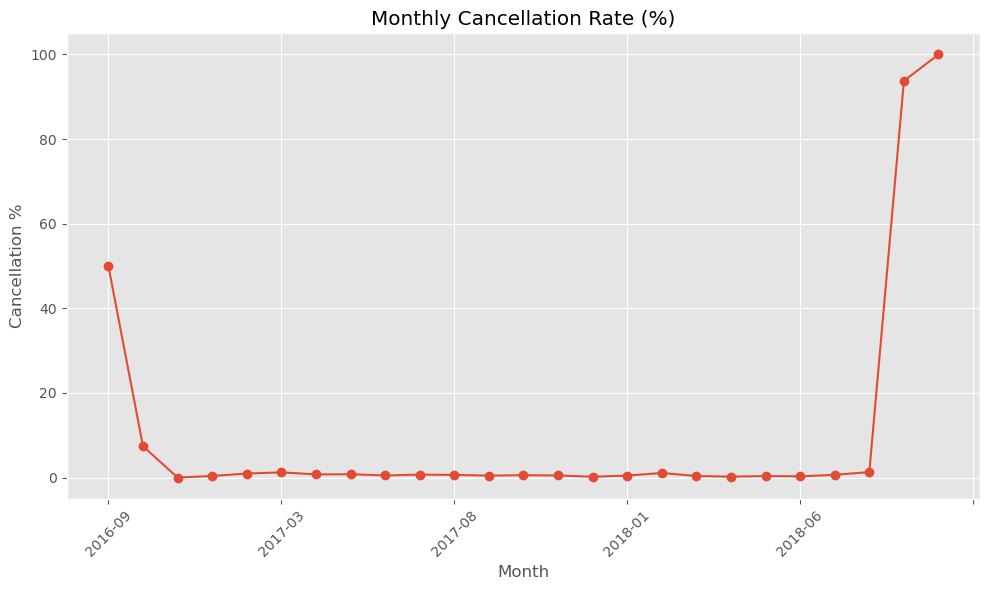

In [44]:
plt.figure()
cancel_rate.plot(kind='line', marker='o')
plt.title('Monthly Cancellation Rate (%)')
plt.xlabel('Month')
plt.ylabel('Cancellation %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<h3>Q10 – Which words pop up most often in review titles?</h3>

In [45]:
titles_series = reviews['review_comment_title'].dropna()
all_titles = ' '.join(titles_series)

wordcloud = WordCloud(width=800, height=400,
                      stopwords=STOPWORDS,
                      background_color='white').generate(all_titles)

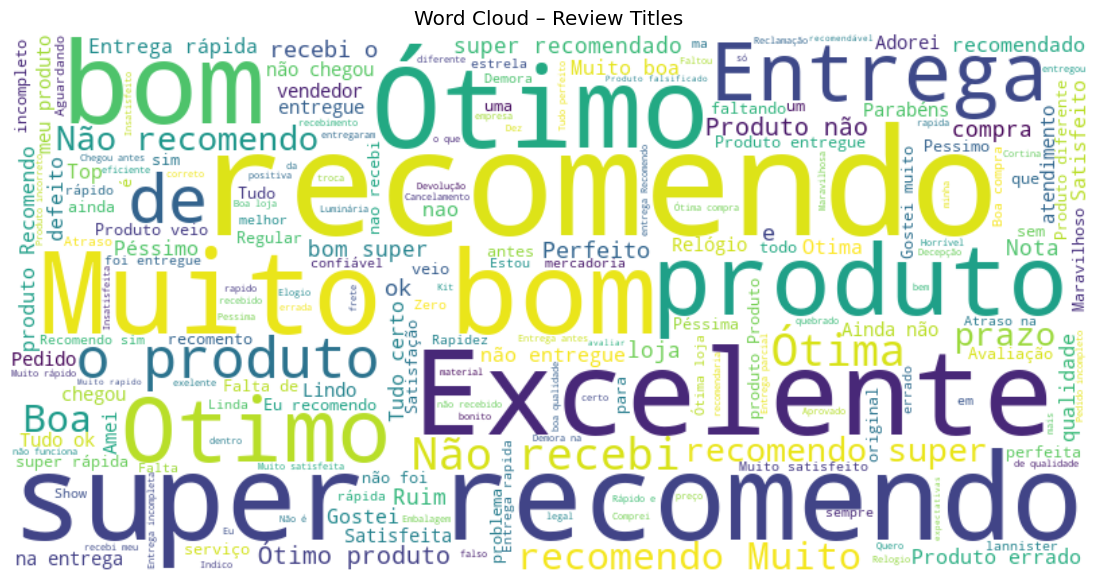

In [46]:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud – Review Titles')
plt.show()